In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Subset
import time
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split

import pickle
from tqdm import tqdm
import copy

In [2]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
from pyro.infer.autoguide import AutoDiagonalNormal

c:\Users\Revalda Putawara\.conda\envs\bnntest\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import pandas as pd

In [4]:
import numpy as np
from sklearn.metrics import confusion_matrix

In [5]:
from utils.model import LaplaceBayesianCNNSingleFC

In [6]:
from bitflip import bitflip_float32

In [7]:
def load_data(batch_size=54):
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.3444, 0.3809, 0.4082], std=[0.1809, 0.1331, 0.1137])
    ])

    dataset = datasets.EuroSAT(root='./data', transform=transform, download=False)

    torch.manual_seed(42)
    
    with open('datasplit/split_indices.pkl', 'rb') as f:
        split = pickle.load(f)
        train_dataset = Subset(dataset, split['train'])
        test_dataset = Subset(dataset, split['test'])

    # Add num_workers and pin_memory for faster data loading
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                             num_workers=4, pin_memory=True, persistent_workers=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size,
                            num_workers=4, pin_memory=True, persistent_workers=True)
    return train_loader, test_loader

In [8]:
train_loader, test_loader = load_data(batch_size=54)

In [9]:
device = torch.device("cuda")

In [10]:
num_classes = 10

In [11]:
bayesian_model = LaplaceBayesianCNNSingleFC(num_classes=num_classes, device=device).to(device)

In [12]:
model_path = 'results_eurosat/bayesian_cnn_model_std10_20_epoch_laplace.pth'
guide_path = 'results_eurosat/bayesian_cnn_guide_std10_20_epoch_guide_laplace.pth'
pyro_param_store_path = 'results_eurosat/pyro_param_store_std10_20_epoch_laplace.pkl'

#guide = AutoDiagonalNormal(bayesian_model).to(device)

#pyro.get_param_store().set_state(torch.load(pyro_param_store_path,weights_only=False))

#original_param_store = {}

#for name, value in pyro.get_param_store().items():
#    print(f"{name}: {value.shape}")
#    original_param_store[name] = torch.tensor(value.data, requires_grad=value.requires_grad)

In [13]:
class Injector:
    def __init__(self, trained_model, device, test_loader, num_samples):
        """
        Initializes SEU injector
        """

        #initialize device
        if device is None:
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        else:
            self.device = device

        self.trained_model = trained_model.to(self.device)
        self.test_loader = test_loader
        self.trained_model.eval()
        self.num_samples = num_samples
        
        self.guide = AutoDiagonalNormal(self.trained_model).to(self.device)
        pyro.get_param_store().clear()
        pyro.get_param_store().set_state(torch.load(pyro_param_store_path,weights_only=False))

        #initial_Accuracy = self.return_accuracy(num_samples)
        initial_labels, initial_predictions, initial_logits, initial_probs = self.predict_data_probs(self.num_samples)
        self.initial_accuracy = self.return_accuracy(initial_labels, initial_predictions)
        
        #print accuracy before SEU
        print(f"Initial accuracy: {self.initial_accuracy}")
        
    def predict_data_probs(self, num_samples=10):
        all_labels = []
        all_predictions = []
        all_logits = []
        all_probs = []

        with torch.no_grad():
            for images, labels in tqdm(self.test_loader, desc="Evaluating"):
                images, labels = images.to(self.device), labels.to(self.device)

                logits_mc = torch.zeros(num_samples, images.size(0), self.trained_model.fc1.out_features).to(device)

                for i in range(num_samples):
                    guide_trace = pyro.poutine.trace(self.guide).get_trace(images)
                    replayed_model = pyro.poutine.replay(self.trained_model, trace=guide_trace)
                    logits = replayed_model(images)
                    logits_mc[i] = logits

                avg_logits = logits_mc.mean(dim=0)
                predictions = torch.argmax(avg_logits, dim=1)

                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predictions.cpu().numpy())
                all_logits.extend(avg_logits.cpu().numpy())
                all_probs.extend(F.softmax(avg_logits, dim=1).cpu().numpy())

        return all_labels, all_predictions, all_logits, all_probs

    def return_accuracy(self, all_labels, all_predictions):
        #all_labels, all_predictions, all_logits, all_probs = self.predict_data_probs(num_samples)
        cm = confusion_matrix(all_labels, all_predictions)
        accuracy = np.trace(cm) / np.sum(cm)

        return accuracy
    
    def run_seu_autodiagonal_normal(self, location_index, bit_i, parameter_name="loc", num_samples=10):
        """
        Run SEU on the AutoDiagonalNormal guide
        """

        assert parameter_name in ["loc", "scale"], "Parameter name must be 'loc' or 'scale'."
        assert bit_i in range(0, 33), "Location index must be between 0 and 9."

        if parameter_name == "loc":
            param_store_name = "AutoDiagonalNormal.loc"
        elif parameter_name == "scale":
            param_store_name = "AutoDiagonalNormal.scale"

        pyro.get_param_store().set_state(torch.load(pyro_param_store_path,weights_only=False))

        with torch.no_grad():
            param_dict = {}

            for name, value in pyro.get_param_store().items():
                #print(f"{name}: {value.shape}")
                #print(value)
                param_dict[name] = value.cpu().detach().numpy()

            tensor_cpu = param_dict[param_store_name]

            #original_val = tensor_cpu[0] #this zero index should be changed to the location_index
            original_val = tensor_cpu[location_index]
            seu_val = bitflip_float32(original_val, bit_i)


            print(f"Original value: {original_val}, SEU value: {seu_val}")

            # Get the parameter
            param = pyro.get_param_store().get_param(param_store_name)

            # Modify it safely by creating a new tensor
            new_param = param.clone()
            new_param[location_index] = seu_val  # New Value

            # Update the parameter store
            if parameter_name == "loc":
                pyro.get_param_store().__setitem__(param_store_name, new_param) # 74%
                #param_store[param_store_name].data.copy_(change_item(param_store_name, location_index, seu_val)) #25%
                #pyro.get_param_store()[param_store_name].data[location_index] = seu_val # 25%
            elif parameter_name == "scale":
                pyro.get_param_store().__setitem__(param_store_name, new_param) #10%
                #pyro.get_param_store()[param_store_name].data[location_index] = seu_val

        #print accuracy after SEU
        self.guide = AutoDiagonalNormal(bayesian_model).to(device)
    

        try:
            after_labels, after_predictions, after_logits, after_probs = self.predict_data_probs(num_samples)
            accuracyAfter_SEU = self.return_accuracy(after_labels, after_predictions)
        except:
            accuracyAfter_SEU = np.nan
            
        print(f"Accuracy after SEU: {accuracyAfter_SEU}")
        print("===================================")

        return accuracyAfter_SEU - self.initial_accuracy
    
    def run_seu_autodiagonal_normal_multi(self, location_indices, bit_i, parameter_name="loc", attack_ratio=1.0, num_samples=10, seed=None):
        """
        Run SEU on the AutoDiagonalNormal guide with multiple location attacks
        
        Args:
            location_indices: list of indices or single index to attack
            bit_i: bit position to flip (0-32)
            parameter_name: "loc" or "scale"
            attack_ratio: ratio of locations to attack (0.0-1.0)
            num_samples: number of MC samples for evaluation
            seed: random seed for reproducible attacks
        """
        
        assert parameter_name in ["loc", "scale"], "Parameter name must be 'loc' or 'scale'."
        assert bit_i in range(0, 33), "Bit index must be between 0 and 32."
        assert 0.0 <= attack_ratio <= 1.0, "Attack ratio must be between 0.0 and 1.0."
        
        # Convert single index to list for uniform handling
        if isinstance(location_indices, int):
            location_indices = [location_indices]
        
        # Set random seed if provided
        if seed is not None:
            np.random.seed(seed)
            torch.manual_seed(seed)
        
        # Calculate number of locations to attack
        num_attacks = max(1, int(len(location_indices) * attack_ratio))
        
        # Randomly select locations to attack
        attack_locations = np.random.choice(location_indices, size=num_attacks, replace=False)
        
        if parameter_name == "loc":
            param_store_name = "AutoDiagonalNormal.loc"
        elif parameter_name == "scale":
            param_store_name = "AutoDiagonalNormal.scale"

        # Reset parameter store to original state
        pyro.get_param_store().set_state(torch.load(pyro_param_store_path, weights_only=False))

        with torch.no_grad():
            # Get the parameter
            param = pyro.get_param_store().get_param(param_store_name)
            
            # Create a new tensor to modify
            new_param = param.clone()
            
            print(f"Attacking {num_attacks} out of {len(location_indices)} locations:")
            
            # Attack each selected location
            for location_index in attack_locations:
                original_val = new_param[location_index].cpu().item()
                seu_val = bitflip_float32(original_val, bit_i)
                new_param[location_index] = seu_val
                
                print(f"  Location {location_index}: {original_val} -> {seu_val}")
            
            # Update the parameter store
            pyro.get_param_store().__setitem__(param_store_name, new_param)

        # Reinitialize guide with modified parameters
        self.guide = AutoDiagonalNormal(bayesian_model).to(device)

        try:
            after_labels, after_predictions, after_logits, after_probs = self.predict_data_probs(num_samples)
            accuracyAfter_SEU = self.return_accuracy(after_labels, after_predictions)
        except:
            accuracyAfter_SEU = np.nan
            
        print(f"Accuracy after SEU: {accuracyAfter_SEU}")
        print("===================================")

        return accuracyAfter_SEU - self.initial_accuracy

In [14]:
inj = Injector(trained_model=bayesian_model, device=device, test_loader=test_loader, num_samples=10)

Evaluating: 100%|██████████| 100/100 [00:23<00:00,  4.34it/s]

Initial accuracy: 0.6161111111111112


In [ ]:
#inj.run_seu_autodiagonal_normal(location_index=0, bit_i=1, parameter_name="scale", num_samples=10)
inj.run_seu_autodiagonal_normal(location_index=0, bit_i=2, parameter_name="loc", num_samples=10)

In [ ]:
#store the result in dataframe
import pandas as pd
results = []

for i in range(0, 32):
    results.append(inj.run_seu_autodiagonal_normal(location_index=0, bit_i=i, parameter_name="scale", num_samples=10))

In [ ]:
# plot the result in matplotlib
plt.figure(figsize=(10, 5))
plt.plot(range(0, 32), results, marker='o')
plt.title('SEU Impact on Scale Parameter')
plt.xlabel('Bit Position')
plt.ylabel('Change in Accuracy')
plt.grid()
plt.show()

In [15]:
results_loc = []

for i in range(0, 32):
    results_loc.append(inj.run_seu_autodiagonal_normal(location_index=0, bit_i=i, parameter_name="loc", num_samples=10))

Original value: 2.205974817276001, SEU value: -2.205974817276001


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 14.62it/s]


Accuracy after SEU: 0.6114814814814815
Original value: 2.205974817276001, SEU value: 1.2106111705979603e-39


Evaluating: 100%|██████████| 100/100 [00:07<00:00, 14.00it/s]


Accuracy after SEU: 0.6140740740740741
Original value: 2.205974817276001, SEU value: 4.069305288733858e+19


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 14.55it/s]


Accuracy after SEU: 0.24296296296296296
Original value: 2.205974817276001, SEU value: 9474589696.0


Evaluating: 100%|██████████| 100/100 [00:07<00:00, 14.24it/s]


Accuracy after SEU: 0.24259259259259258
Original value: 2.205974817276001, SEU value: 144570.765625


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.09it/s]


Accuracy after SEU: 0.24333333333333335
Original value: 2.205974817276001, SEU value: 564.7295532226562


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.08it/s]


Accuracy after SEU: 0.2798148148148148
Original value: 2.205974817276001, SEU value: 35.295597076416016


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.18it/s]


Accuracy after SEU: 0.5314814814814814
Original value: 2.205974817276001, SEU value: 8.823899269104004


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.06it/s]


Accuracy after SEU: 0.6107407407407407
Original value: 2.205974817276001, SEU value: 4.411949634552002


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 14.98it/s]


Accuracy after SEU: 0.6140740740740741
Original value: 2.205974817276001, SEU value: 3.205974817276001


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 14.94it/s]


Accuracy after SEU: 0.6175925925925926
Original value: 2.205974817276001, SEU value: 2.705974817276001


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 14.98it/s]


Accuracy after SEU: 0.6144444444444445
Original value: 2.205974817276001, SEU value: 2.455974817276001


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 14.43it/s]


Accuracy after SEU: 0.6144444444444445
Original value: 2.205974817276001, SEU value: 2.080974817276001


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 14.83it/s]


Accuracy after SEU: 0.6148148148148148
Original value: 2.205974817276001, SEU value: 2.143474817276001


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.25it/s]


Accuracy after SEU: 0.6166666666666667
Original value: 2.205974817276001, SEU value: 2.237224817276001


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.07it/s]


Accuracy after SEU: 0.6159259259259259
Original value: 2.205974817276001, SEU value: 2.190349817276001


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.71it/s]


Accuracy after SEU: 0.615
Original value: 2.205974817276001, SEU value: 2.213787317276001


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.83it/s]


Accuracy after SEU: 0.6148148148148148
Original value: 2.205974817276001, SEU value: 2.209881067276001


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.70it/s]


Accuracy after SEU: 0.6151851851851852
Original value: 2.205974817276001, SEU value: 2.204021692276001


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.97it/s]


Accuracy after SEU: 0.6140740740740741
Original value: 2.205974817276001, SEU value: 2.206951379776001


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.94it/s]


Accuracy after SEU: 0.617037037037037
Original value: 2.205974817276001, SEU value: 2.205486536026001


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.79it/s]


Accuracy after SEU: 0.6140740740740741
Original value: 2.205974817276001, SEU value: 2.205730676651001


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.54it/s]


Accuracy after SEU: 0.6162962962962963
Original value: 2.205974817276001, SEU value: 2.205852746963501


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.90it/s]


Accuracy after SEU: 0.6144444444444445
Original value: 2.205974817276001, SEU value: 2.206035852432251


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.59it/s]


Accuracy after SEU: 0.6179629629629629
Original value: 2.205974817276001, SEU value: 2.205944299697876


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.90it/s]


Accuracy after SEU: 0.6192592592592593
Original value: 2.205974817276001, SEU value: 2.2059900760650635


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.99it/s]


Accuracy after SEU: 0.6125925925925926
Original value: 2.205974817276001, SEU value: 2.2059671878814697


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.94it/s]


Accuracy after SEU: 0.6125925925925926
Original value: 2.205974817276001, SEU value: 2.2059710025787354


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 16.01it/s]


Accuracy after SEU: 0.6116666666666667
Original value: 2.205974817276001, SEU value: 2.205976724624634


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 14.86it/s]


Accuracy after SEU: 0.6140740740740741
Original value: 2.205974817276001, SEU value: 2.2059757709503174


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.57it/s]


Accuracy after SEU: 0.6162962962962963
Original value: 2.205974817276001, SEU value: 2.205975294113159


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.74it/s]


Accuracy after SEU: 0.6155555555555555
Original value: 2.205974817276001, SEU value: 2.205974578857422


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.13it/s]

Accuracy after SEU: 0.6151851851851852


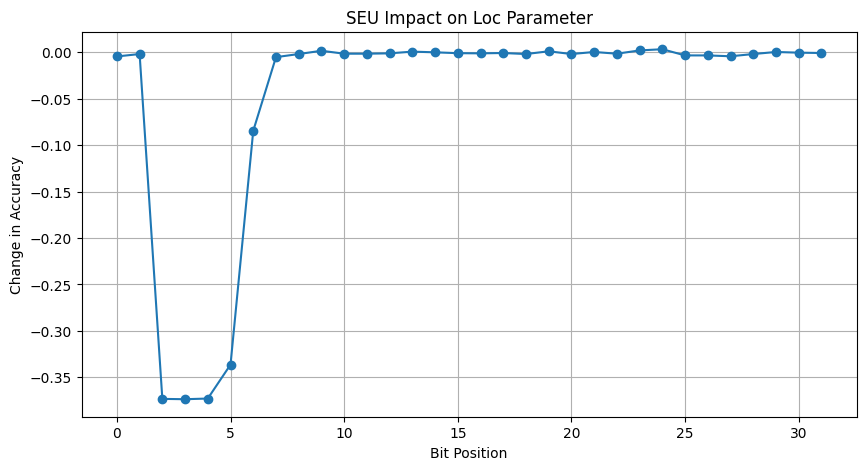

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(range(0, 32), results_loc, marker='o')
plt.title('SEU Impact on Loc Parameter')
plt.xlabel('Bit Position')
plt.ylabel('Change in Accuracy')
plt.grid()
plt.show()

In [17]:
#(inj.run_seu_autodiagonal_normal(location_index=0, bit_i=0, parameter_name="loc", num_samples=10))

In [18]:
results2_loc = []

for i in range(0, 32):
    results2_loc.append(inj.run_seu_autodiagonal_normal(location_index=217536, bit_i=i, parameter_name="loc", num_samples=10))

Original value: 1.631324291229248, SEU value: -1.631324291229248


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.16it/s]


Accuracy after SEU: 0.6161111111111112
Original value: 1.631324291229248, SEU value: nan


Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]


Accuracy after SEU: nan
Original value: 1.631324291229248, SEU value: 8.843426702895632e-20


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.18it/s]


Accuracy after SEU: 0.6124074074074074
Original value: 1.631324291229248, SEU value: 3.798222847350985e-10


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.83it/s]


Accuracy after SEU: 0.615
Original value: 1.631324291229248, SEU value: 2.4892033252399415e-05


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.89it/s]


Accuracy after SEU: 0.6166666666666667
Original value: 1.631324291229248, SEU value: 0.00637236051261425


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.87it/s]


Accuracy after SEU: 0.6137037037037038
Original value: 1.631324291229248, SEU value: 0.101957768201828


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.86it/s]


Accuracy after SEU: 0.612037037037037
Original value: 1.631324291229248, SEU value: 0.407831072807312


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.90it/s]


Accuracy after SEU: 0.6155555555555555
Original value: 1.631324291229248, SEU value: 0.815662145614624


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.39it/s]


Accuracy after SEU: 0.6153703703703703
Original value: 1.631324291229248, SEU value: 1.131324291229248


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.54it/s]


Accuracy after SEU: 0.6138888888888889
Original value: 1.631324291229248, SEU value: 1.881324291229248


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 14.84it/s]


Accuracy after SEU: 0.6161111111111112
Original value: 1.631324291229248, SEU value: 1.506324291229248


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.30it/s]


Accuracy after SEU: 0.6133333333333333
Original value: 1.631324291229248, SEU value: 1.693824291229248


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 14.82it/s]


Accuracy after SEU: 0.6140740740740741
Original value: 1.631324291229248, SEU value: 1.662574291229248


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.49it/s]


Accuracy after SEU: 0.6140740740740741
Original value: 1.631324291229248, SEU value: 1.646949291229248


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.51it/s]


Accuracy after SEU: 0.6166666666666667
Original value: 1.631324291229248, SEU value: 1.639136791229248


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.42it/s]


Accuracy after SEU: 0.6133333333333333
Original value: 1.631324291229248, SEU value: 1.627418041229248


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.48it/s]


Accuracy after SEU: 0.6168518518518519
Original value: 1.631324291229248, SEU value: 1.629371166229248


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.06it/s]


Accuracy after SEU: 0.6157407407407407
Original value: 1.631324291229248, SEU value: 1.632300853729248


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.02it/s]


Accuracy after SEU: 0.6153703703703703
Original value: 1.631324291229248, SEU value: 1.631812572479248


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.59it/s]


Accuracy after SEU: 0.6109259259259259
Original value: 1.631324291229248, SEU value: 1.631080150604248


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.64it/s]


Accuracy after SEU: 0.6144444444444445
Original value: 1.631324291229248, SEU value: 1.631202220916748


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.53it/s]


Accuracy after SEU: 0.6175925925925926
Original value: 1.631324291229248, SEU value: 1.631263256072998


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.39it/s]


Accuracy after SEU: 0.6135185185185185
Original value: 1.631324291229248, SEU value: 1.631293773651123


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.47it/s]


Accuracy after SEU: 0.6137037037037038
Original value: 1.631324291229248, SEU value: 1.6313395500183105


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.42it/s]


Accuracy after SEU: 0.612037037037037
Original value: 1.631324291229248, SEU value: 1.6313319206237793


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.44it/s]


Accuracy after SEU: 0.6166666666666667
Original value: 1.631324291229248, SEU value: 1.6313204765319824


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.33it/s]


Accuracy after SEU: 0.6157407407407407
Original value: 1.631324291229248, SEU value: 1.6313223838806152


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.00it/s]


Accuracy after SEU: 0.6161111111111112
Original value: 1.631324291229248, SEU value: 1.6313233375549316


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 14.85it/s]


Accuracy after SEU: 0.6140740740740741
Original value: 1.631324291229248, SEU value: 1.6313238143920898


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.12it/s]


Accuracy after SEU: 0.6166666666666667
Original value: 1.631324291229248, SEU value: 1.6313245296478271


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.43it/s]


Accuracy after SEU: 0.6138888888888889
Original value: 1.631324291229248, SEU value: 1.6313244104385376


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.35it/s]

Accuracy after SEU: 0.6151851851851852


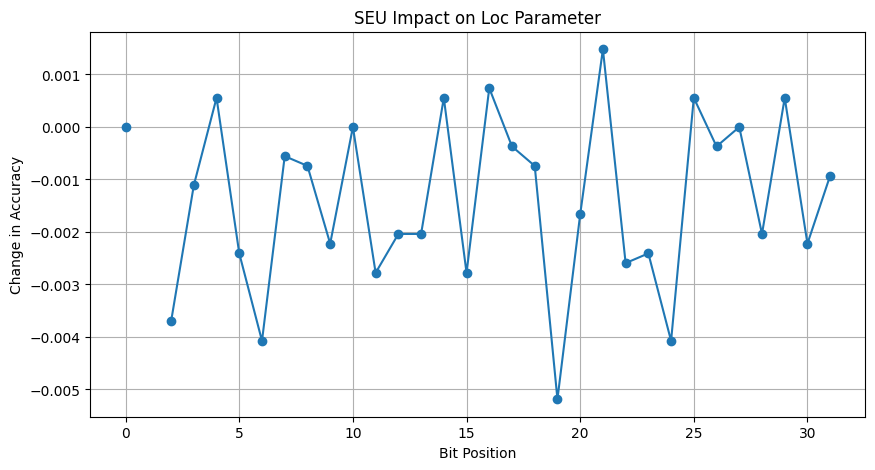

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(range(0, 32), results2_loc, marker='o')
plt.title('SEU Impact on Loc Parameter')
plt.xlabel('Bit Position')
plt.ylabel('Change in Accuracy')
plt.grid()
plt.show()

In [20]:
bayesian_model

LaplaceBayesianCNNSingleFC(
  (conv1): PyroConv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): PyroConv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): PyroLinear(in_features=16384, out_features=10, bias=True)
)

In [21]:
# print the parameters of the bayesian model
for name, value in bayesian_model.named_parameters():
    print(f"{name}: {value.shape}")

In [22]:
# print the parameters of pyro param store
for name, value in pyro.get_param_store().items():
    print(f"{name}: {value.shape}")

AutoDiagonalNormal.loc: torch.Size([217546])
AutoDiagonalNormal.scale: torch.Size([217546])


In [23]:
results3_loc = []

for i in range(0, 32):
    results3_loc.append(inj.run_seu_autodiagonal_normal(location_index=53696, bit_i=i, parameter_name="loc", num_samples=10))

Original value: 3.480041027069092, SEU value: -3.480041027069092


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.33it/s]


Accuracy after SEU: 0.6133333333333333
Original value: 3.480041027069092, SEU value: 8.698899331524669e-39


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 14.55it/s]


Accuracy after SEU: 0.615
Original value: 3.480041027069092, SEU value: 6.419542619235287e+19


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.45it/s]


Accuracy after SEU: 0.547962962962963
Original value: 3.480041027069092, SEU value: 14946662400.0


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.60it/s]


Accuracy after SEU: 0.5457407407407407
Original value: 3.480041027069092, SEU value: 228067.96875


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.36it/s]


Accuracy after SEU: 0.552037037037037
Original value: 3.480041027069092, SEU value: 890.8905029296875


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.32it/s]


Accuracy after SEU: 0.5866666666666667
Original value: 3.480041027069092, SEU value: 55.68065643310547


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.42it/s]


Accuracy after SEU: 0.6109259259259259
Original value: 3.480041027069092, SEU value: 13.920164108276367


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.33it/s]


Accuracy after SEU: 0.6138888888888889
Original value: 3.480041027069092, SEU value: 6.960082054138184


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.66it/s]


Accuracy after SEU: 0.6159259259259259
Original value: 3.480041027069092, SEU value: 2.480041027069092


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 14.74it/s]


Accuracy after SEU: 0.6127777777777778
Original value: 3.480041027069092, SEU value: 3.980041027069092


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.21it/s]


Accuracy after SEU: 0.6122222222222222
Original value: 3.480041027069092, SEU value: 3.230041027069092


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.22it/s]


Accuracy after SEU: 0.6092592592592593
Original value: 3.480041027069092, SEU value: 3.355041027069092


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.25it/s]


Accuracy after SEU: 0.617037037037037
Original value: 3.480041027069092, SEU value: 3.417541027069092


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.06it/s]


Accuracy after SEU: 0.6142592592592593
Original value: 3.480041027069092, SEU value: 3.448791027069092


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.10it/s]


Accuracy after SEU: 0.6142592592592593
Original value: 3.480041027069092, SEU value: 3.495666027069092


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 14.58it/s]


Accuracy after SEU: 0.6135185185185185
Original value: 3.480041027069092, SEU value: 3.472228527069092


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 14.99it/s]


Accuracy after SEU: 0.6142592592592593
Original value: 3.480041027069092, SEU value: 3.483947277069092


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.01it/s]


Accuracy after SEU: 0.6116666666666667
Original value: 3.480041027069092, SEU value: 3.478087902069092


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.31it/s]


Accuracy after SEU: 0.6151851851851852
Original value: 3.480041027069092, SEU value: 3.479064464569092


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.37it/s]


Accuracy after SEU: 0.6129629629629629
Original value: 3.480041027069092, SEU value: 3.479552745819092


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.36it/s]


Accuracy after SEU: 0.6144444444444445
Original value: 3.480041027069092, SEU value: 3.480285167694092


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 14.89it/s]


Accuracy after SEU: 0.6135185185185185
Original value: 3.480041027069092, SEU value: 3.480163097381592


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.26it/s]


Accuracy after SEU: 0.6168518518518519
Original value: 3.480041027069092, SEU value: 3.480102062225342


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.22it/s]


Accuracy after SEU: 0.6168518518518519
Original value: 3.480041027069092, SEU value: 3.480010509490967


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.12it/s]


Accuracy after SEU: 0.6177777777777778
Original value: 3.480041027069092, SEU value: 3.4800257682800293


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.20it/s]


Accuracy after SEU: 0.615
Original value: 3.480041027069092, SEU value: 3.4800333976745605


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.12it/s]


Accuracy after SEU: 0.6146296296296296
Original value: 3.480041027069092, SEU value: 3.480037212371826


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.46it/s]


Accuracy after SEU: 0.6133333333333333
Original value: 3.480041027069092, SEU value: 3.480039119720459


Evaluating: 100%|██████████| 100/100 [00:07<00:00, 13.97it/s]


Accuracy after SEU: 0.6148148148148148
Original value: 3.480041027069092, SEU value: 3.4800400733947754


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.01it/s]


Accuracy after SEU: 0.6151851851851852
Original value: 3.480041027069092, SEU value: 3.4800405502319336


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.08it/s]


Accuracy after SEU: 0.6133333333333333
Original value: 3.480041027069092, SEU value: 3.480041265487671


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.26it/s]

Accuracy after SEU: 0.6127777777777778


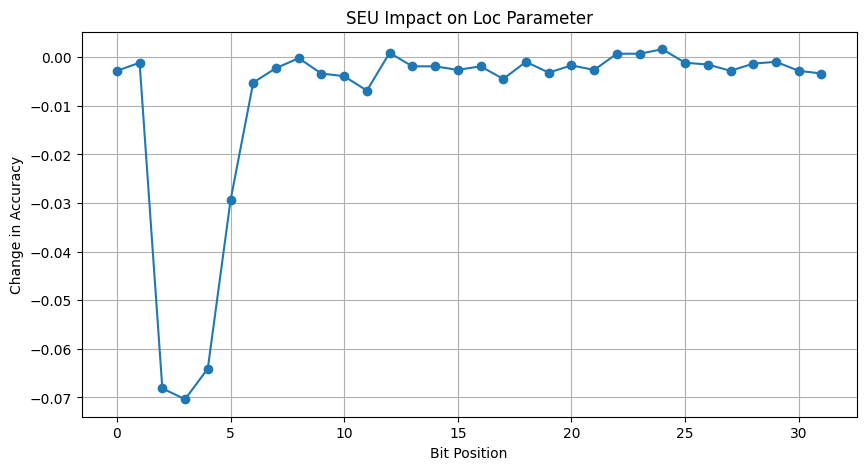

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(range(0, 32), results3_loc, marker='o')
plt.title('SEU Impact on Loc Parameter')
plt.xlabel('Bit Position')
plt.ylabel('Change in Accuracy')
plt.grid()
plt.show()

In [25]:
import numpy as np

def get_flat_param_index(layer_name, param_type, index_tuple):
    # Define parameter shapes for each layer
    param_shapes = {
        'conv1': {
            'weight': (32, 3, 5, 5),
            'bias': (32,)
        },
        'conv2': {
            'weight': (64, 32, 5, 5),
            'bias': (64,)
        },
        'fc1': {
            'weight': (10, 16384),
            'bias': (10,)
        }
    }

    # Check valid inputs
    if layer_name not in param_shapes:
        raise ValueError(f"Unknown layer '{layer_name}'")
    if param_type not in param_shapes[layer_name]:
        raise ValueError(f"'{param_type}' not found in layer '{layer_name}'")

    # Compute flat offset for each param in order: conv1.weight, conv1.bias, ...
    flat_offset = 0
    for l in ['conv1', 'conv2', 'fc1']:
        for p in ['weight', 'bias']:
            shape = param_shapes[l][p]
            numel = np.prod(shape)

            if l == layer_name and p == param_type:
                # Compute local flat index within this param
                local_flat_index = np.ravel_multi_index(index_tuple, shape)
                return flat_offset + local_flat_index

            flat_offset += numel

    raise RuntimeError("Should not reach here if input is valid.")


In [26]:
# Index of conv1.bias[5]
print(get_flat_param_index("conv1", "bias", (0,)))  # Output: 2405

# Index of conv2.weight[0,0,0,0]
print(get_flat_param_index("conv2", "weight", (0,0,0,0)))  # Output: 2432

# Index of fc1.weight[0, 0]
print(get_flat_param_index("fc1", "weight", (0, 0)))  # Output: 53696

2400
2432
53696


In [27]:
results4_loc = []

for i in range(0, 32):
    results4_loc.append(inj.run_seu_autodiagonal_normal(location_index=2400, bit_i=i, parameter_name="loc", num_samples=10))

Original value: 0.03050355613231659, SEU value: -0.03050355613231659


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.03it/s]


Accuracy after SEU: 0.6161111111111112
Original value: 0.03050355613231659, SEU value: 1.0379822280210396e+37


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.50it/s]


Accuracy after SEU: 0.1111111111111111
Original value: 0.03050355613231659, SEU value: 1.6536010913595589e-21


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.24it/s]


Accuracy after SEU: 0.6148148148148148
Original value: 0.03050355613231659, SEU value: 7.1021626080192135e-12


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 14.94it/s]


Accuracy after SEU: 0.6157407407407407
Original value: 0.03050355613231659, SEU value: 4.654473286791472e-07


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.07it/s]


Accuracy after SEU: 0.612037037037037
Original value: 0.03050355613231659, SEU value: 0.00011915451614186168


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.05it/s]


Accuracy after SEU: 0.6144444444444445
Original value: 0.03050355613231659, SEU value: 0.48805689811706543


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.10it/s]


Accuracy after SEU: 0.615
Original value: 0.03050355613231659, SEU value: 0.12201422452926636


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.10it/s]


Accuracy after SEU: 0.6144444444444445
Original value: 0.03050355613231659, SEU value: 0.015251778066158295


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.02it/s]


Accuracy after SEU: 0.615
Original value: 0.03050355613231659, SEU value: 0.02269105613231659


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.05it/s]


Accuracy after SEU: 0.6157407407407407
Original value: 0.03050355613231659, SEU value: 0.02659730613231659


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.04it/s]


Accuracy after SEU: 0.6153703703703703
Original value: 0.03050355613231659, SEU value: 0.02855043113231659


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.17it/s]


Accuracy after SEU: 0.6181481481481481
Original value: 0.03050355613231659, SEU value: 0.02952699363231659


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.17it/s]


Accuracy after SEU: 0.617037037037037
Original value: 0.03050355613231659, SEU value: 0.03099183738231659


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.12it/s]


Accuracy after SEU: 0.6140740740740741
Original value: 0.03050355613231659, SEU value: 0.03074769675731659


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.11it/s]


Accuracy after SEU: 0.6101851851851852
Original value: 0.03050355613231659, SEU value: 0.03038148581981659


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.20it/s]


Accuracy after SEU: 0.6146296296296296
Original value: 0.03050355613231659, SEU value: 0.03044252097606659


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.11it/s]


Accuracy after SEU: 0.6112962962962963
Original value: 0.03050355613231659, SEU value: 0.03047303855419159


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 14.92it/s]


Accuracy after SEU: 0.6144444444444445
Original value: 0.03050355613231659, SEU value: 0.03048829734325409


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 14.90it/s]


Accuracy after SEU: 0.6159259259259259
Original value: 0.03050355613231659, SEU value: 0.03051118552684784


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.25it/s]


Accuracy after SEU: 0.615
Original value: 0.03050355613231659, SEU value: 0.030507370829582214


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.07it/s]


Accuracy after SEU: 0.6166666666666667
Original value: 0.03050355613231659, SEU value: 0.030505463480949402


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.18it/s]


Accuracy after SEU: 0.6164814814814815
Original value: 0.03050355613231659, SEU value: 0.030502602458000183


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.08it/s]


Accuracy after SEU: 0.6146296296296296
Original value: 0.03050355613231659, SEU value: 0.030504032969474792


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.27it/s]


Accuracy after SEU: 0.6157407407407407
Original value: 0.03050355613231659, SEU value: 0.030503317713737488


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.42it/s]


Accuracy after SEU: 0.6131481481481481
Original value: 0.03050355613231659, SEU value: 0.03050367534160614


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.14it/s]


Accuracy after SEU: 0.6162962962962963
Original value: 0.03050355613231659, SEU value: 0.030503615736961365


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.26it/s]


Accuracy after SEU: 0.617037037037037
Original value: 0.03050355613231659, SEU value: 0.0305035263299942


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.30it/s]


Accuracy after SEU: 0.6116666666666667
Original value: 0.03050355613231659, SEU value: 0.030503541231155396


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.34it/s]


Accuracy after SEU: 0.6137037037037038
Original value: 0.03050355613231659, SEU value: 0.030503563582897186


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.34it/s]


Accuracy after SEU: 0.6151851851851852
Original value: 0.03050355613231659, SEU value: 0.030503559857606888


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.28it/s]


Accuracy after SEU: 0.6161111111111112
Original value: 0.03050355613231659, SEU value: 0.03050355799496174


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.22it/s]

Accuracy after SEU: 0.6125925925925926


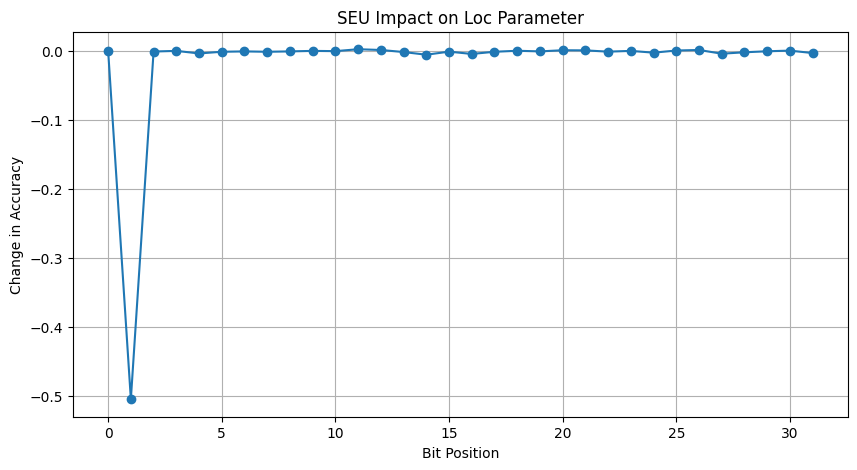

In [28]:
plt.figure(figsize=(10, 5))
plt.plot(range(0, 32), results4_loc, marker='o')
plt.title('SEU Impact on Loc Parameter')
plt.xlabel('Bit Position')
plt.ylabel('Change in Accuracy')
plt.grid()
plt.show()

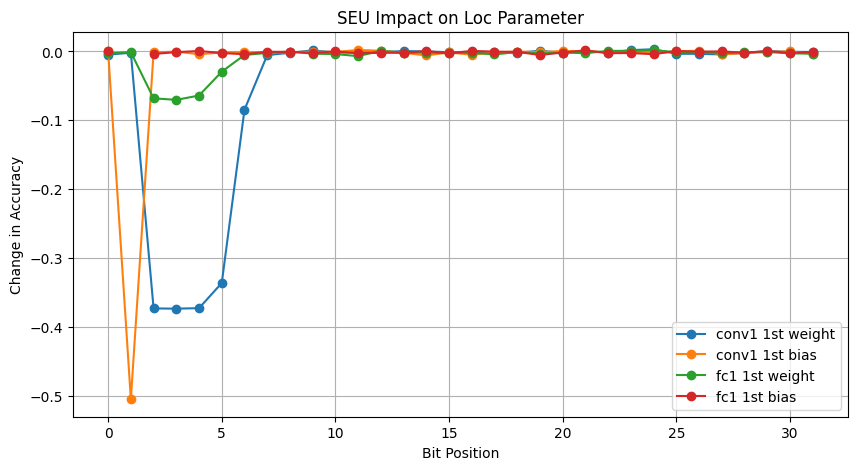

In [29]:
# plot results2_loc, results3_loc, results4_loc in a single plot
plt.figure(figsize=(10, 5))
plt.plot(range(0, 32), results_loc, marker='o', label='conv1 1st weight')
plt.plot(range(0, 32), results4_loc, marker='o', label='conv1 1st bias')
plt.plot(range(0, 32), results3_loc, marker='o', label='fc1 1st weight')
plt.plot(range(0, 32), results2_loc, marker='o', label='fc1 1st bias')


plt.title('SEU Impact on Loc Parameter')
plt.xlabel('Bit Position')
plt.ylabel('Change in Accuracy')
plt.grid()
plt.legend()
plt.show()

In [30]:
#results
#results2_scale
#...
#...

In [31]:
results_scale = []

for i in range(0, 32):
    results_scale.append(inj.run_seu_autodiagonal_normal(location_index=0, bit_i=i, parameter_name="scale", num_samples=10))

Original value: 0.09152799844741821, SEU value: -0.09152799844741821


Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]


Accuracy after SEU: nan
Original value: 0.09152799844741821, SEU value: 3.114536395122345e+37


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.02it/s]


Accuracy after SEU: 0.11296296296296296
Original value: 0.09152799844741821, SEU value: 4.961742737997035e-21


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 14.90it/s]


Accuracy after SEU: 0.6122222222222222
Original value: 0.09152799844741821, SEU value: 2.1310522790862763e-11


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.07it/s]


Accuracy after SEU: 0.6135185185185185
Original value: 0.09152799844741821, SEU value: 1.396606421621982e-06


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 14.97it/s]


Accuracy after SEU: 0.6155555555555555
Original value: 0.09152799844741821, SEU value: 0.0003575312439352274


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.12it/s]


Accuracy after SEU: 0.6133333333333333
Original value: 0.09152799844741821, SEU value: 1.4644479751586914


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 14.89it/s]


Accuracy after SEU: 0.6185185185185185
Original value: 0.09152799844741821, SEU value: 0.022881999611854553


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 14.53it/s]


Accuracy after SEU: 0.6138888888888889
Original value: 0.09152799844741821, SEU value: 0.045763999223709106


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 14.92it/s]


Accuracy after SEU: 0.6125925925925926
Original value: 0.09152799844741821, SEU value: 0.12277799844741821


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.01it/s]


Accuracy after SEU: 0.6151851851851852
Original value: 0.09152799844741821, SEU value: 0.07590299844741821


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.07it/s]


Accuracy after SEU: 0.6177777777777778
Original value: 0.09152799844741821, SEU value: 0.08371549844741821


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.10it/s]


Accuracy after SEU: 0.6122222222222222
Original value: 0.09152799844741821, SEU value: 0.08762174844741821


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.09it/s]


Accuracy after SEU: 0.6124074074074074
Original value: 0.09152799844741821, SEU value: 0.09348112344741821


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.00it/s]


Accuracy after SEU: 0.6137037037037038
Original value: 0.09152799844741821, SEU value: 0.09055143594741821


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.27it/s]


Accuracy after SEU: 0.6161111111111112
Original value: 0.09152799844741821, SEU value: 0.09103971719741821


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.43it/s]


Accuracy after SEU: 0.6124074074074074
Original value: 0.09152799844741821, SEU value: 0.09177213907241821


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.28it/s]


Accuracy after SEU: 0.6138888888888889
Original value: 0.09152799844741821, SEU value: 0.09140592813491821


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.30it/s]


Accuracy after SEU: 0.6129629629629629
Original value: 0.09152799844741821, SEU value: 0.09146696329116821


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.22it/s]


Accuracy after SEU: 0.6153703703703703
Original value: 0.09152799844741821, SEU value: 0.09149748086929321


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.22it/s]


Accuracy after SEU: 0.6164814814814815
Original value: 0.09152799844741821, SEU value: 0.09154325723648071


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.03it/s]


Accuracy after SEU: 0.6112962962962963
Original value: 0.09152799844741821, SEU value: 0.09153562784194946


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.18it/s]


Accuracy after SEU: 0.6144444444444445
Original value: 0.09152799844741821, SEU value: 0.09152418375015259


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.11it/s]


Accuracy after SEU: 0.6155555555555555
Original value: 0.09152799844741821, SEU value: 0.0915260910987854


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.00it/s]


Accuracy after SEU: 0.6172222222222222
Original value: 0.09152799844741821, SEU value: 0.09152895212173462


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.16it/s]


Accuracy after SEU: 0.6111111111111112
Original value: 0.09152799844741821, SEU value: 0.09152847528457642


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.21it/s]


Accuracy after SEU: 0.6164814814814815
Original value: 0.09152799844741821, SEU value: 0.09152823686599731


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.00it/s]


Accuracy after SEU: 0.6155555555555555
Original value: 0.09152799844741821, SEU value: 0.09152811765670776


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.43it/s]


Accuracy after SEU: 0.6144444444444445
Original value: 0.09152799844741821, SEU value: 0.09152793884277344


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.41it/s]


Accuracy after SEU: 0.6168518518518519
Original value: 0.09152799844741821, SEU value: 0.0915280282497406


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.32it/s]


Accuracy after SEU: 0.6155555555555555
Original value: 0.09152799844741821, SEU value: 0.0915280133485794


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.27it/s]


Accuracy after SEU: 0.615
Original value: 0.09152799844741821, SEU value: 0.09152800589799881


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.27it/s]

Accuracy after SEU: 0.6122222222222222


In [32]:
#store the result in dataframe
import pandas as pd
results2_scale = []

for i in range(0, 32):
    results2_scale.append(inj.run_seu_autodiagonal_normal(location_index=217536, bit_i=i, parameter_name="scale", num_samples=10))

Original value: 1.9306310415267944, SEU value: -1.9306310415267944


Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]


Accuracy after SEU: nan
Original value: 1.9306310415267944, SEU value: nan


Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]


Accuracy after SEU: nan
Original value: 1.9306310415267944, SEU value: 1.0465971847456513e-19


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.08it/s]


Accuracy after SEU: 0.6177777777777778
Original value: 1.9306310415267944, SEU value: 4.4951006805682425e-10


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.03it/s]


Accuracy after SEU: 0.6131481481481481
Original value: 1.9306310415267944, SEU value: 2.9459091820172034e-05


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 14.79it/s]


Accuracy after SEU: 0.615
Original value: 1.9306310415267944, SEU value: 0.007541527505964041


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 14.90it/s]


Accuracy after SEU: 0.617037037037037
Original value: 1.9306310415267944, SEU value: 0.12066444009542465


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.20it/s]


Accuracy after SEU: 0.6116666666666667
Original value: 1.9306310415267944, SEU value: 0.4826577603816986


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.12it/s]


Accuracy after SEU: 0.6148148148148148
Original value: 1.9306310415267944, SEU value: 0.9653155207633972


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.20it/s]


Accuracy after SEU: 0.6166666666666667
Original value: 1.9306310415267944, SEU value: 1.4306310415267944


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.20it/s]


Accuracy after SEU: 0.6153703703703703
Original value: 1.9306310415267944, SEU value: 1.6806310415267944


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.21it/s]


Accuracy after SEU: 0.6107407407407407
Original value: 1.9306310415267944, SEU value: 1.8056310415267944


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.19it/s]


Accuracy after SEU: 0.6162962962962963
Original value: 1.9306310415267944, SEU value: 1.9931310415267944


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.18it/s]


Accuracy after SEU: 0.6129629629629629
Original value: 1.9306310415267944, SEU value: 1.8993810415267944


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.20it/s]


Accuracy after SEU: 0.6166666666666667
Original value: 1.9306310415267944, SEU value: 1.9150060415267944


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.25it/s]


Accuracy after SEU: 0.6138888888888889
Original value: 1.9306310415267944, SEU value: 1.9228185415267944


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.22it/s]


Accuracy after SEU: 0.6142592592592593
Original value: 1.9306310415267944, SEU value: 1.9345372915267944


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.22it/s]


Accuracy after SEU: 0.6125925925925926
Original value: 1.9306310415267944, SEU value: 1.9325841665267944


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.06it/s]


Accuracy after SEU: 0.6131481481481481
Original value: 1.9306310415267944, SEU value: 1.9316076040267944


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.18it/s]


Accuracy after SEU: 0.6153703703703703
Original value: 1.9306310415267944, SEU value: 1.9301427602767944


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.12it/s]


Accuracy after SEU: 0.6161111111111112
Original value: 1.9306310415267944, SEU value: 1.9303869009017944


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.27it/s]


Accuracy after SEU: 0.6135185185185185
Original value: 1.9306310415267944, SEU value: 1.9305089712142944


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.01it/s]


Accuracy after SEU: 0.6122222222222222
Original value: 1.9306310415267944, SEU value: 1.9305700063705444


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.20it/s]


Accuracy after SEU: 0.6116666666666667
Original value: 1.9306310415267944, SEU value: 1.9306615591049194


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.33it/s]


Accuracy after SEU: 0.6175925925925926
Original value: 1.9306310415267944, SEU value: 1.930615782737732


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.17it/s]


Accuracy after SEU: 0.6131481481481481
Original value: 1.9306310415267944, SEU value: 1.9306234121322632


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.21it/s]


Accuracy after SEU: 0.6137037037037038
Original value: 1.9306310415267944, SEU value: 1.9306272268295288


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.19it/s]


Accuracy after SEU: 0.6183333333333333
Original value: 1.9306310415267944, SEU value: 1.9306329488754272


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.13it/s]


Accuracy after SEU: 0.6140740740740741
Original value: 1.9306310415267944, SEU value: 1.930630087852478


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.07it/s]


Accuracy after SEU: 0.6146296296296296
Original value: 1.9306310415267944, SEU value: 1.9306315183639526


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.09it/s]


Accuracy after SEU: 0.6135185185185185
Original value: 1.9306310415267944, SEU value: 1.9306308031082153


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 14.91it/s]


Accuracy after SEU: 0.6131481481481481
Original value: 1.9306310415267944, SEU value: 1.9306309223175049


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.17it/s]

Accuracy after SEU: 0.6146296296296296


In [33]:
#store the result in dataframe
import pandas as pd
results3_scale = []

for i in range(0, 32):
    results3_scale.append(inj.run_seu_autodiagonal_normal(location_index=53696, bit_i=i, parameter_name="scale", num_samples=10))

Original value: 0.1124204620718956, SEU value: -0.1124204620718956


Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]


Accuracy after SEU: nan
Original value: 0.1124204620718956, SEU value: 3.8254700924170224e+37


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.34it/s]


Accuracy after SEU: 0.5518518518518518
Original value: 0.1124204620718956, SEU value: 6.094325460508673e-21


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.36it/s]


Accuracy after SEU: 0.615
Original value: 0.1124204620718956, SEU value: 2.617492854406489e-11


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.04it/s]


Accuracy after SEU: 0.6137037037037038
Original value: 0.1124204620718956, SEU value: 1.7154001170638367e-06


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.27it/s]


Accuracy after SEU: 0.6148148148148148
Original value: 0.1124204620718956, SEU value: 0.0004391424299683422


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.29it/s]


Accuracy after SEU: 0.617037037037037
Original value: 0.1124204620718956, SEU value: 1.7987273931503296


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.26it/s]


Accuracy after SEU: 0.6157407407407407
Original value: 0.1124204620718956, SEU value: 0.0281051155179739


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.31it/s]


Accuracy after SEU: 0.6118518518518519
Original value: 0.1124204620718956, SEU value: 0.0562102310359478


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.16it/s]


Accuracy after SEU: 0.6131481481481481
Original value: 0.1124204620718956, SEU value: 0.0811704620718956


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.01it/s]


Accuracy after SEU: 0.6181481481481481
Original value: 0.1124204620718956, SEU value: 0.0967954620718956


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 14.87it/s]


Accuracy after SEU: 0.6162962962962963
Original value: 0.1124204620718956, SEU value: 0.1202329620718956


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 14.89it/s]


Accuracy after SEU: 0.6146296296296296
Original value: 0.1124204620718956, SEU value: 0.1163267120718956


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.22it/s]


Accuracy after SEU: 0.6129629629629629
Original value: 0.1124204620718956, SEU value: 0.1104673370718956


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.24it/s]


Accuracy after SEU: 0.615
Original value: 0.1124204620718956, SEU value: 0.1114438995718956


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.24it/s]


Accuracy after SEU: 0.6188888888888889
Original value: 0.1124204620718956, SEU value: 0.1129087433218956


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 14.86it/s]


Accuracy after SEU: 0.6148148148148148
Original value: 0.1124204620718956, SEU value: 0.1126646026968956


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.29it/s]


Accuracy after SEU: 0.6124074074074074
Original value: 0.1124204620718956, SEU value: 0.1125425323843956


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.22it/s]


Accuracy after SEU: 0.6133333333333333
Original value: 0.1124204620718956, SEU value: 0.1123594269156456


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.27it/s]


Accuracy after SEU: 0.6164814814814815
Original value: 0.1124204620718956, SEU value: 0.1123899444937706


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.11it/s]


Accuracy after SEU: 0.6144444444444445
Original value: 0.1124204620718956, SEU value: 0.1124052032828331


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.28it/s]


Accuracy after SEU: 0.615
Original value: 0.1124204620718956, SEU value: 0.11241283267736435


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.15it/s]


Accuracy after SEU: 0.6131481481481481
Original value: 0.1124204620718956, SEU value: 0.11242427676916122


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 14.94it/s]


Accuracy after SEU: 0.6131481481481481
Original value: 0.1124204620718956, SEU value: 0.11242236942052841


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.05it/s]


Accuracy after SEU: 0.615
Original value: 0.1124204620718956, SEU value: 0.1124195083975792


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.27it/s]


Accuracy after SEU: 0.6133333333333333
Original value: 0.1124204620718956, SEU value: 0.1124209389090538


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.15it/s]


Accuracy after SEU: 0.6148148148148148
Original value: 0.1124204620718956, SEU value: 0.1124202236533165


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.18it/s]


Accuracy after SEU: 0.6161111111111112
Original value: 0.1124204620718956, SEU value: 0.11242034286260605


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.15it/s]


Accuracy after SEU: 0.6177777777777778
Original value: 0.1124204620718956, SEU value: 0.11242052167654037


Evaluating: 100%|██████████| 100/100 [00:07<00:00, 13.30it/s]


Accuracy after SEU: 0.6157407407407407
Original value: 0.1124204620718956, SEU value: 0.11242049187421799


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.80it/s]


Accuracy after SEU: 0.6122222222222222
Original value: 0.1124204620718956, SEU value: 0.1124204471707344


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.86it/s]


Accuracy after SEU: 0.6172222222222222
Original value: 0.1124204620718956, SEU value: 0.112420454621315


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.76it/s]

Accuracy after SEU: 0.6162962962962963


In [34]:
#store the result in dataframe
import pandas as pd
results4_scale = []

for i in range(0, 32):
    results4_scale.append(inj.run_seu_autodiagonal_normal(location_index=2400, bit_i=i, parameter_name="scale", num_samples=10))

Original value: 0.09087348729372025, SEU value: -0.09087348729372025


Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]


Accuracy after SEU: nan
Original value: 0.09087348729372025, SEU value: 3.092264534666695e+37


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.29it/s]


Accuracy after SEU: 0.1111111111111111
Original value: 0.09087348729372025, SEU value: 4.926261617259269e-21


Evaluating: 100%|██████████| 100/100 [00:09<00:00, 11.06it/s]


Accuracy after SEU: 0.6179629629629629
Original value: 0.09087348729372025, SEU value: 2.1158132537668628e-11


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.84it/s]


Accuracy after SEU: 0.6148148148148148
Original value: 0.09087348729372025, SEU value: 1.3866193739886512e-06


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.88it/s]


Accuracy after SEU: 0.6161111111111112
Original value: 0.09087348729372025, SEU value: 0.0003549745597410947


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.82it/s]


Accuracy after SEU: 0.6148148148148148
Original value: 0.09087348729372025, SEU value: 1.453975796699524


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.97it/s]


Accuracy after SEU: 0.6166666666666667
Original value: 0.09087348729372025, SEU value: 0.02271837182343006


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.96it/s]


Accuracy after SEU: 0.6137037037037038
Original value: 0.09087348729372025, SEU value: 0.04543674364686012


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 12.00it/s]


Accuracy after SEU: 0.6138888888888889
Original value: 0.09087348729372025, SEU value: 0.12212348729372025


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.95it/s]


Accuracy after SEU: 0.6155555555555555
Original value: 0.09087348729372025, SEU value: 0.07524848729372025


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.90it/s]


Accuracy after SEU: 0.6142592592592593
Original value: 0.09087348729372025, SEU value: 0.08306098729372025


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.86it/s]


Accuracy after SEU: 0.6144444444444445
Original value: 0.09087348729372025, SEU value: 0.08696723729372025


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.93it/s]


Accuracy after SEU: 0.6140740740740741
Original value: 0.09087348729372025, SEU value: 0.09282661229372025


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.90it/s]


Accuracy after SEU: 0.615
Original value: 0.09087348729372025, SEU value: 0.08989692479372025


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.95it/s]


Accuracy after SEU: 0.6138888888888889
Original value: 0.09087348729372025, SEU value: 0.09136176854372025


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.86it/s]


Accuracy after SEU: 0.6187037037037038
Original value: 0.09087348729372025, SEU value: 0.09111762791872025


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.96it/s]


Accuracy after SEU: 0.6124074074074074
Original value: 0.09087348729372025, SEU value: 0.09099555760622025


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.95it/s]


Accuracy after SEU: 0.617037037037037
Original value: 0.09087348729372025, SEU value: 0.09093452244997025


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 12.02it/s]


Accuracy after SEU: 0.6155555555555555
Original value: 0.09087348729372025, SEU value: 0.09084296971559525


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 12.00it/s]


Accuracy after SEU: 0.6172222222222222
Original value: 0.09087348729372025, SEU value: 0.09085822850465775


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.98it/s]


Accuracy after SEU: 0.6168518518518519
Original value: 0.09087348729372025, SEU value: 0.0908811166882515


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.91it/s]


Accuracy after SEU: 0.6151851851851852
Original value: 0.09087348729372025, SEU value: 0.09086967259645462


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.94it/s]


Accuracy after SEU: 0.6131481481481481
Original value: 0.09087348729372025, SEU value: 0.09087157994508743


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.94it/s]


Accuracy after SEU: 0.6181481481481481
Original value: 0.09087348729372025, SEU value: 0.09087253361940384


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 12.03it/s]


Accuracy after SEU: 0.6125925925925926
Original value: 0.09087348729372025, SEU value: 0.09087301045656204


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.99it/s]


Accuracy after SEU: 0.6127777777777778
Original value: 0.09087348729372025, SEU value: 0.09087324887514114


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.98it/s]


Accuracy after SEU: 0.6122222222222222
Original value: 0.09087348729372025, SEU value: 0.0908736065030098


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.88it/s]


Accuracy after SEU: 0.6129629629629629
Original value: 0.09087348729372025, SEU value: 0.09087354689836502


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.73it/s]


Accuracy after SEU: 0.6118518518518519
Original value: 0.09087348729372025, SEU value: 0.09087351709604263


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.49it/s]


Accuracy after SEU: 0.6135185185185185
Original value: 0.09087348729372025, SEU value: 0.09087350219488144


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.45it/s]


Accuracy after SEU: 0.6127777777777778
Original value: 0.09087348729372025, SEU value: 0.09087347984313965


Evaluating: 100%|██████████| 100/100 [00:08<00:00, 11.63it/s]

Accuracy after SEU: 0.6166666666666667


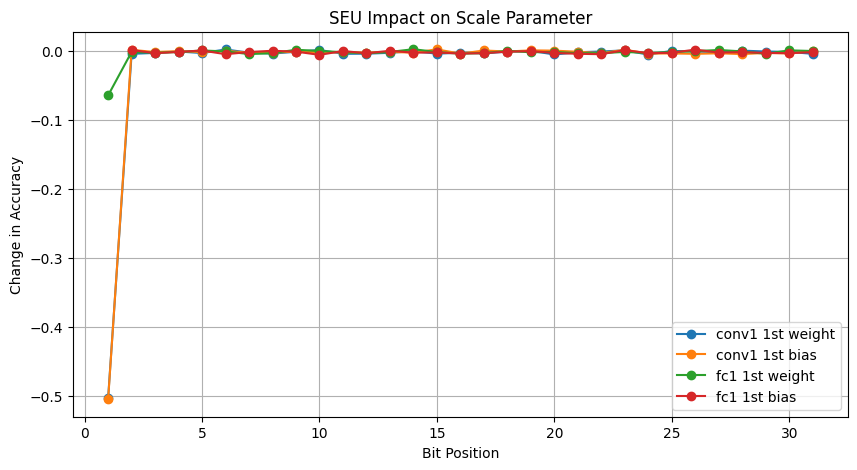

In [35]:
plt.figure(figsize=(10, 5))
plt.plot(range(0, 32), results_scale, marker='o', label='conv1 1st weight')
plt.plot(range(0, 32), results4_scale, marker='o', label='conv1 1st bias')
plt.plot(range(0, 32), results3_scale, marker='o', label='fc1 1st weight')
plt.plot(range(0, 32), results2_scale, marker='o', label='fc1 1st bias')


plt.title('SEU Impact on Scale Parameter')
plt.xlabel('Bit Position')
plt.ylabel('Change in Accuracy')
plt.grid()
plt.legend()
plt.show()

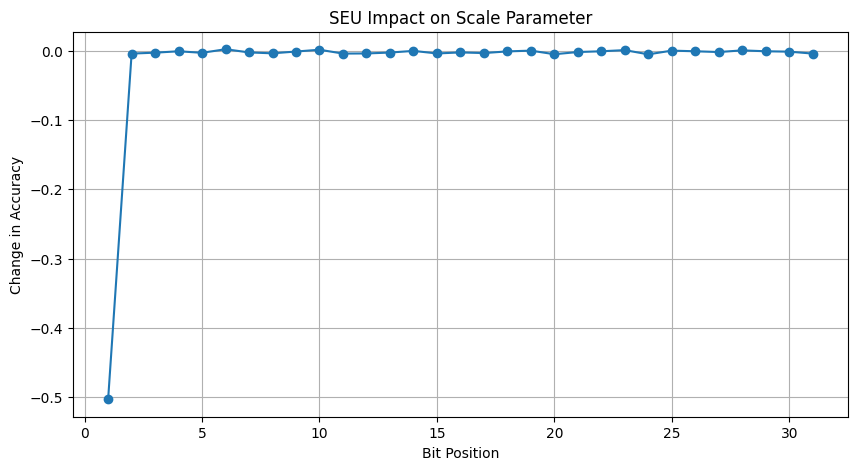

In [36]:
plt.figure(figsize=(10, 5))
plt.plot(range(0, 32), results_scale, marker='o')
plt.title('SEU Impact on Scale Parameter')
plt.xlabel('Bit Position')
plt.ylabel('Change in Accuracy')
plt.grid()
plt.show()

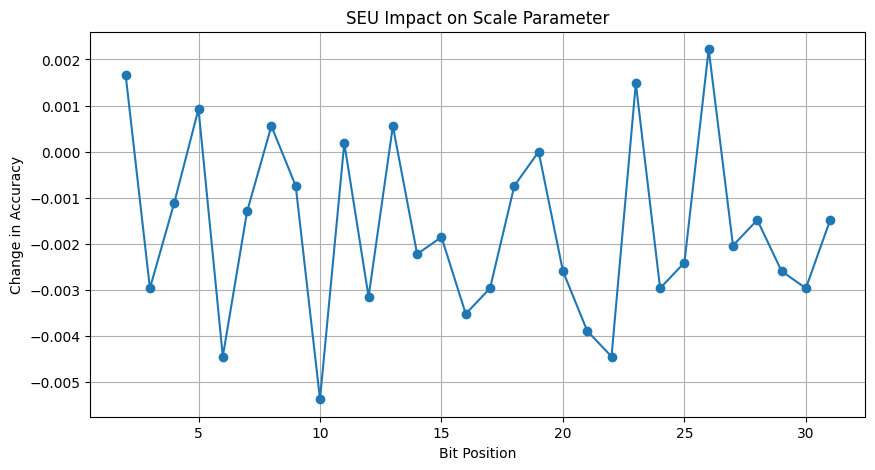

In [37]:
plt.figure(figsize=(10, 5))
plt.plot(range(0, 32), results2_scale, marker='o')
plt.title('SEU Impact on Scale Parameter')
plt.xlabel('Bit Position')
plt.ylabel('Change in Accuracy')
plt.grid()
plt.show()

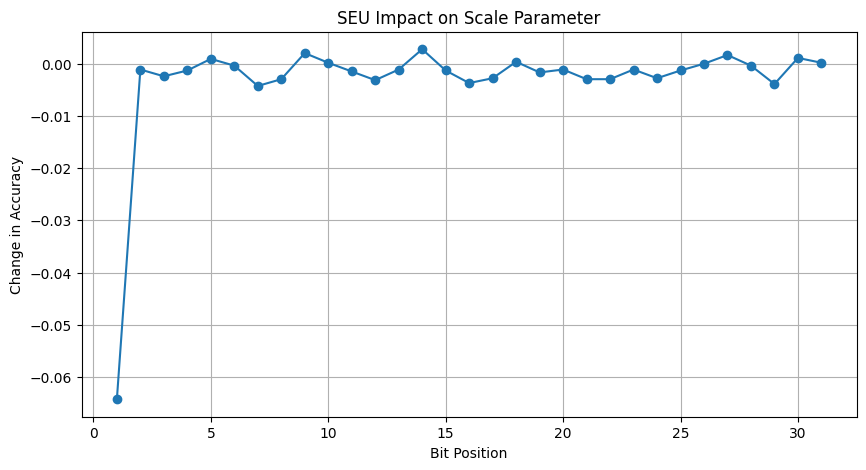

In [38]:
plt.figure(figsize=(10, 5))
plt.plot(range(0, 32), results3_scale, marker='o')
plt.title('SEU Impact on Scale Parameter')
plt.xlabel('Bit Position')
plt.ylabel('Change in Accuracy')
plt.grid()
plt.show()

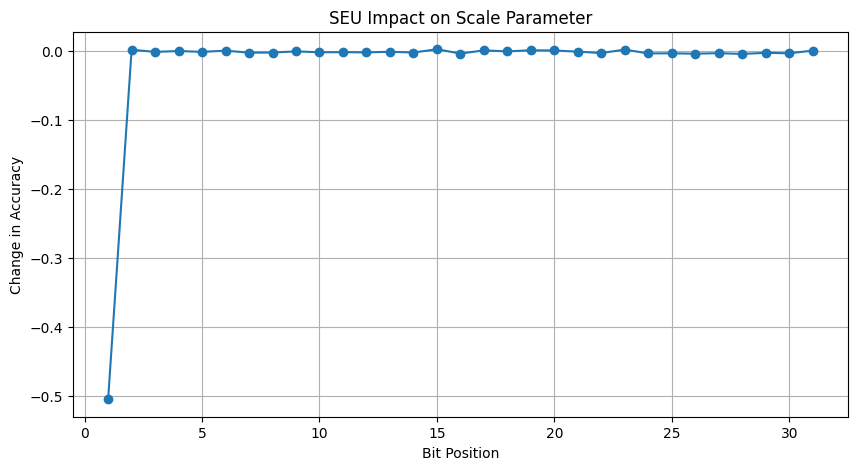

In [39]:
plt.figure(figsize=(10, 5))
plt.plot(range(0, 32), results4_scale, marker='o')
plt.title('SEU Impact on Scale Parameter')
plt.xlabel('Bit Position')
plt.ylabel('Change in Accuracy')
plt.grid()
plt.show()